In [9]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from datetime import datetime
# import dateparser
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


import pmdarima as pm
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

#reading file, not standart delimeter, providing it(;) to pandas
df1=pd.read_csv('../datasets/household_power_consumption.txt', delimiter=';', index_col=["Date"], parse_dates=["Date"])

#rewriting to read from excel
#df.to_csv('../temp/timeser.csv',encoding='utf-16', sep='\t', index=False)
df1.dtypes

Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [10]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_true, y_pred):
    print("R2 score = ", r2_score(y_true, y_pred))
    print("MAE = ", mean_absolute_error(y_true, y_pred))
    print("MedianAE = ", median_absolute_error(y_true, y_pred))
    print("MSE = ", mean_squared_error(y_true, y_pred))
    print("MAPE = ", mean_absolute_percentage_error(y_true, y_pred))

In [11]:
df_real=df1.copy(deep=True)




df_real[['Global_active_power','Global_reactive_power']]=df_real[['Global_active_power','Global_reactive_power']].apply(pd.to_numeric, errors='coerce')

#Calculating total power, like vectorizing sum
#in scalar, formula will be like:
df_real['Total_power']=(df_real['Global_active_power']**2+df_real['Global_reactive_power']**2)**0.5

df_real=df_real.drop(columns= ['Time','Global_active_power','Global_reactive_power', 'Sub_metering_1','Sub_metering_2', 'Sub_metering_3','Voltage','Global_intensity'])
#df_real['Date']=df_real['Date'].apply(pd.to_datetime, errors='coerce')
df_real



,Total_power
Date,
2006-12-16,4.236671
2006-12-16,5.377704
2006-12-16,5.397025
2006-12-16,5.411335
2006-12-16,3.703828
...,...
2010-11-26,0.946000
2010-11-26,0.944000
2010-11-26,0.938000


In [12]:
df_real=df_real.groupby(by=['Date']).mean()
#df_real.loc['2007-01-01']
df_real.info()
#print(df_real.dropna().count())
#print(df_real.count())




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total_power  1433 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


In [13]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
   

In [14]:
df_real['Total_power']=df_real['Total_power'].interpolate(method='time')
df_real.reset_index(inplace=True)
date = pd.DatetimeIndex(df_real['Date'])
df_real.drop(columns='Date', inplace=True)
df_real.set_index(date, inplace=True)
df_real.index.name = 'Date'
df_real=df_real.asfreq('d')

In [15]:
df_real.index

DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='Date', length=1442, freq='D')

In [16]:
ADF_test(df_real)

Results of Dickey-Fuller Test:
Test Statistic                   -3.710666
p-value                           0.003966
Lags Used                        22.000000
Number of Observations Used    1419.000000
Critical Value (1%)              -3.434967
Critical Value (5%)              -2.863579
Critical Value (10%)             -2.567856
dtype: float64


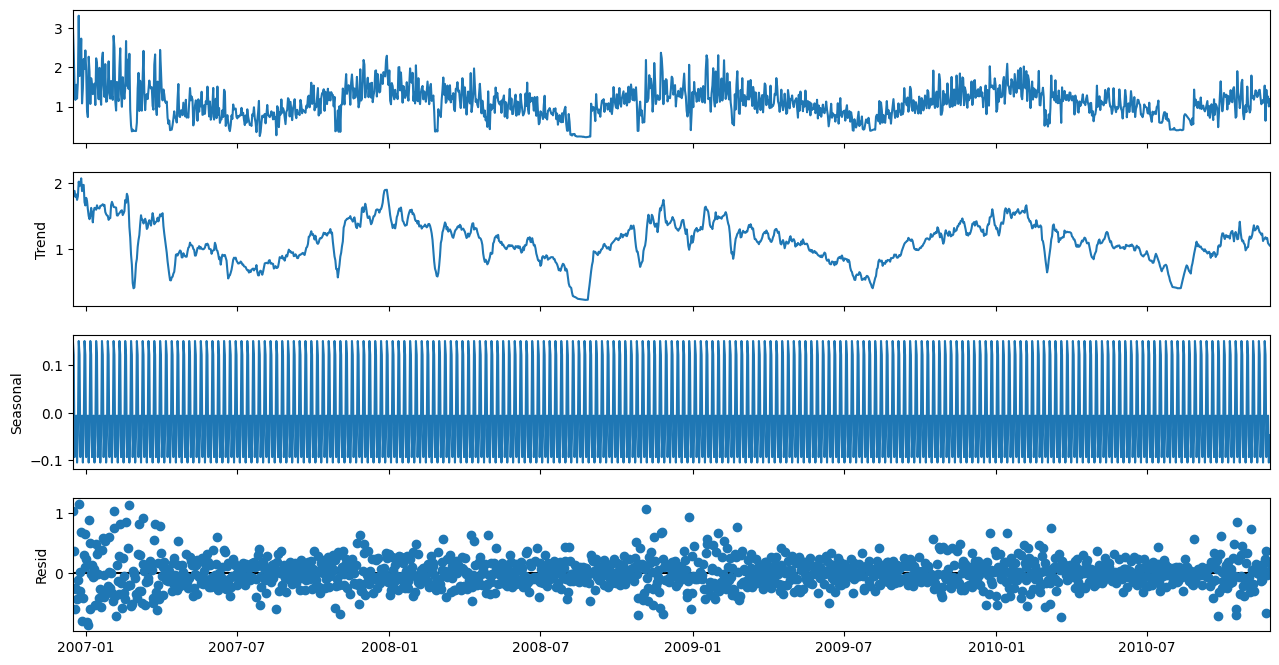

In [17]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', extrapolate_trend=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual
 
trend, seasonal, residual = seasonal_decompose(df_real)

In [18]:
train_data = df_real['Total_power'][:int(len(df_real)*0.8)]
test_data = df_real['Total_power'][int(len(df_real)*0.8):]


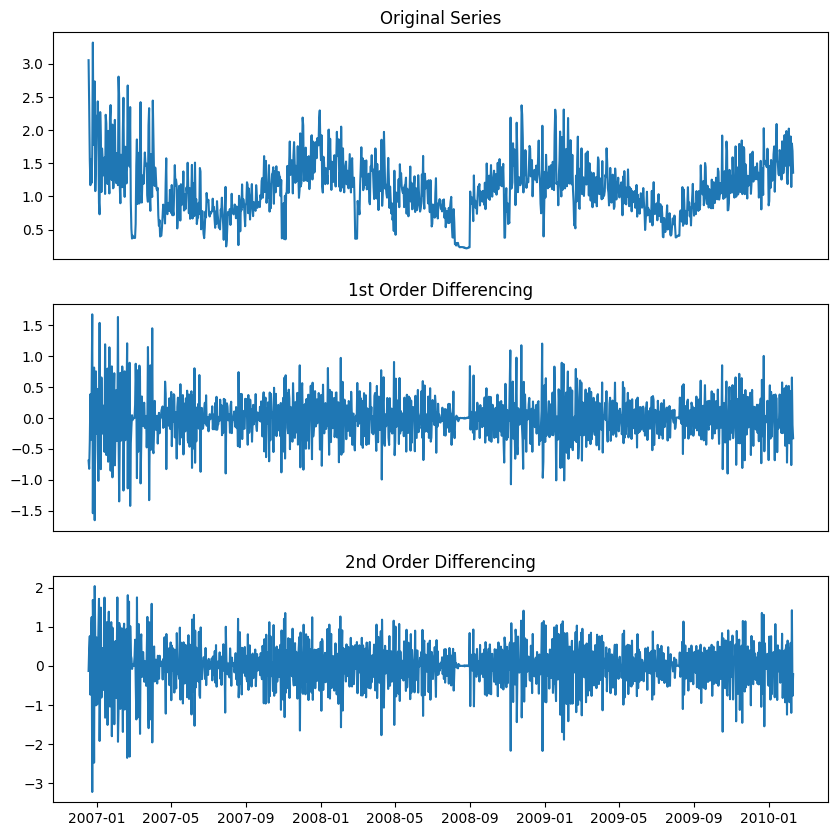

In [19]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 10))
ax1.plot(train_data)
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(train_data.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(train_data.diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()

Text(0.5, 1.0, 'Autocorrelation for second-order differencing')

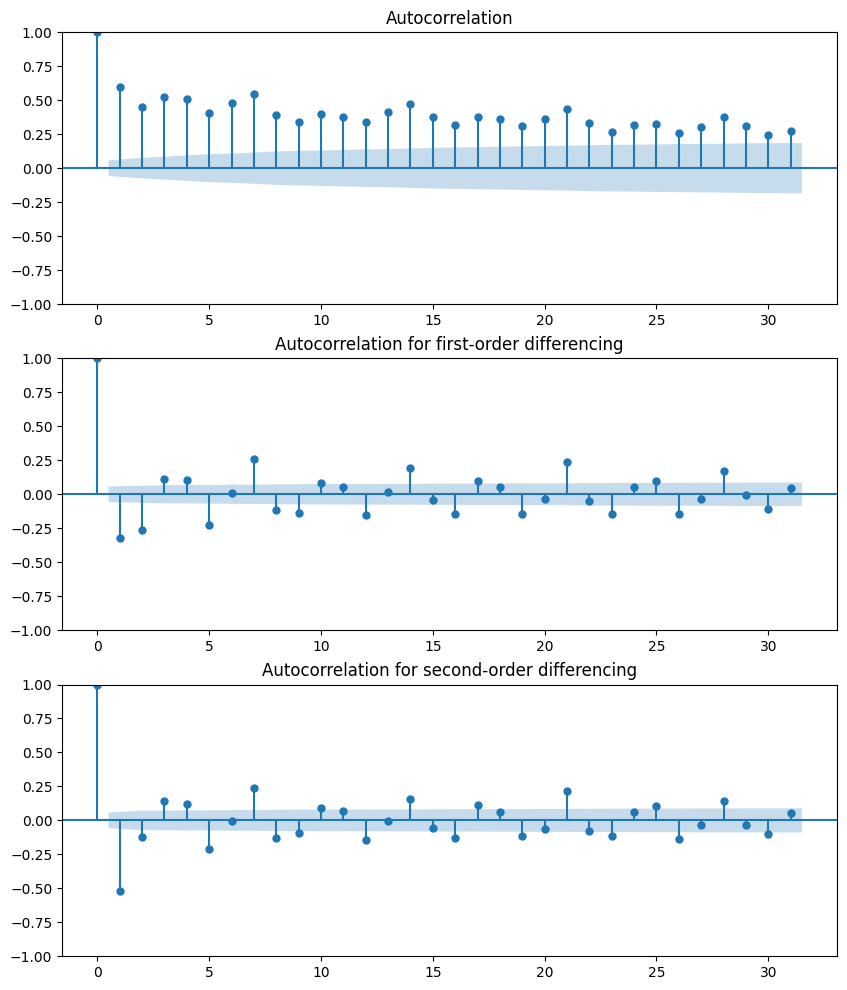

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
_ = plot_acf(train_data, ax=ax1)
_ = plot_acf(train_data.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
_ = plot_acf(train_data.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')

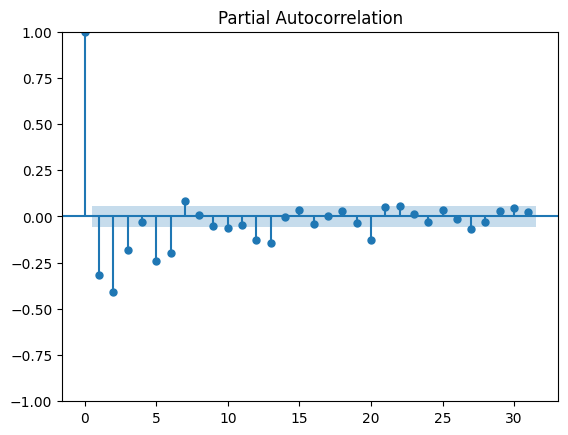

In [21]:
_ = plot_pacf(train_data.diff().dropna())

In [30]:
# Run ADF test to determine order of differencing (d)
result = adfuller(df_real['Total_power'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# If p-value > 0.05, the data are non-stationary and you need to difference the data
if result[1] > 0.05:
    df_real['Total_power'] = df_real['Total_power'].diff().dropna()
    d = 1
else:
    d = 0

ADF Statistic: -3.710666
p-value: 0.003966


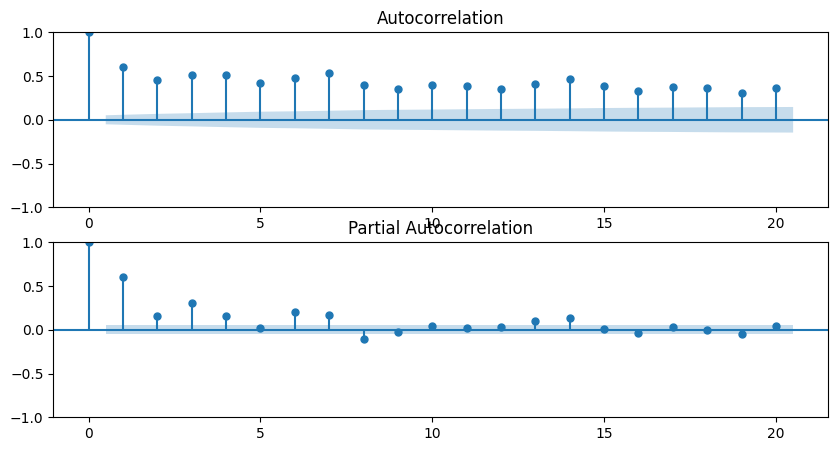

In [29]:
# Plot ACF and PACF charts to find the order of the AR and MA terms
fig, axes = plt.subplots(2, figsize=(10,5))

# Plot the ACF of the differenced series
plot_acf(df_real['Total_power'], lags=20, ax=axes[0])

# Plot the PACF of the differenced series
plot_pacf(df_real['Total_power'], lags=20, ax=axes[1])

plt.show()



In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Set p and q based on the plots
# p is where the PACF crosses the upper confidence interval for the first time
# q is where the ACF crosses the upper confidence interval for the first time
p = 4
d = 3
q = 15

# Build the model
model = SARIMAX(df_real['Total_power'], order=(p, d, q))
model_fit = model.fit(disp=False)

# Print out the summary
print(model_fit.summary())

c:\Mariia_privately\3 курс\Машинне навчання\Labs\Machine-Learning\win-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            Total_power   No. Observations:                 1442
Model:              SARIMAX(4, 3, 15)   Log Likelihood                -308.291
Date:                Sat, 17 Jun 2023   AIC                            656.582
Time:                        11:29:47   BIC                            762.016
Sample:                    12-16-2006   HQIC                           695.942
                         - 11-26-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.6566      0.114    -23.361      0.000      -2.879      -2.434
ar.L2         -3.4048      0.204    -16.661      0.000      -3.805      -3.004
ar.L3         -2.5767      0.204    -12.648      0.0

In [72]:
# Forecast
forecast_steps = 10  # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

print('Forecast: ')
print(forecast)

Forecast: 
2010-11-27    1.263490
2010-11-28    1.170788
2010-11-29    1.309609
2010-11-30    1.309308
2010-12-01    1.292785
2010-12-02    1.301276
2010-12-03    1.319653
2010-12-04    1.358447
2010-12-05    1.349534
2010-12-06    1.382210
Freq: D, Name: predicted_mean, dtype: float64


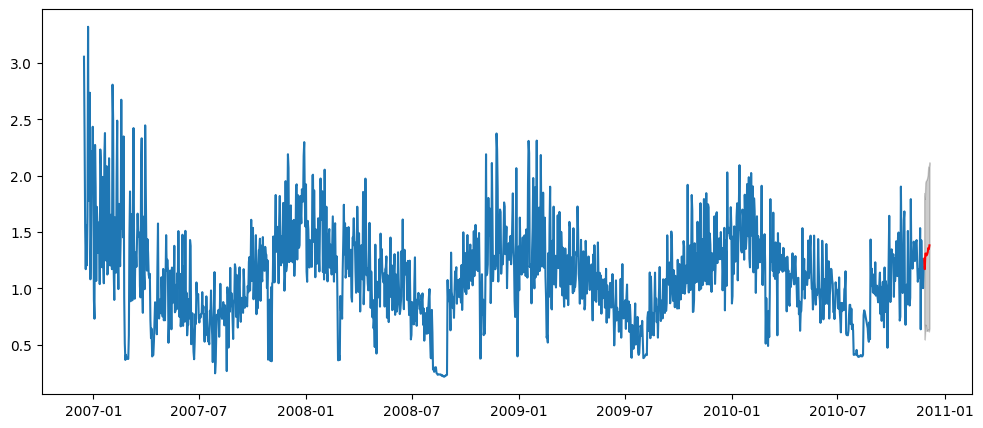

In [73]:
# Get confidence intervals 
prediction = model_fit.get_prediction(start=pd.to_datetime('2010-11-27'), end=pd.to_datetime('2010-12-06'), dynamic=False)
prediction_conf = prediction.conf_int()

# Plot the values and their confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(df_real['Total_power'])
plt.plot(prediction.predicted_mean, color='red')
plt.fill_between(prediction_conf.index, prediction_conf.iloc[:, 0], prediction_conf.iloc[:, 1], color='k', alpha=.2)
plt.show()